## overlap figure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# load data
hummingbirds = pd.read_csv('../../../raw_inaturalist_exports/hummingbirds/observations-395877.csv')
bumblebees = pd.concat([
    pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396610.csv'),
    pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396616.csv')
])

dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')
red_validated = pd.read_csv('../../final_data/validated_FULL_gpt_labeled_REDS_ONLY.csv')

# remove "not red" species from `dat`
not_red_sp = red_validated[red_validated['validated'] == "no"]['binomial'].tolist()
dat.loc[dat['binomial'].isin(not_red_sp), 'color'] = 'nan'
dat = dat[dat['color'] != 'nan']

# add lon_window column based on longitude values
def categorize_longitude(lon):
    if -96 <= lon <= -59:
        return "Lon: -96 to -59"
    elif -130 <= lon < -96:
        return "Lon: -130 to -96"
    else:
        return np.nan

# apply to all 3
for df in [dat, hummingbirds, bumblebees]:
    df['lon_window'] = df['longitude'].apply(categorize_longitude)

# get "day_of_year" for all 3
for df in [dat, hummingbirds, bumblebees]:
    df['day_of_year'] = pd.to_datetime(df['observed_on'], errors='coerce').dt.dayofyear

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_80834/1662797797.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396610.csv'),
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_80834/1662797797.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396616.csv')
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_80834/1662797797.py:8: DtypeWarning: Columns (14,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')


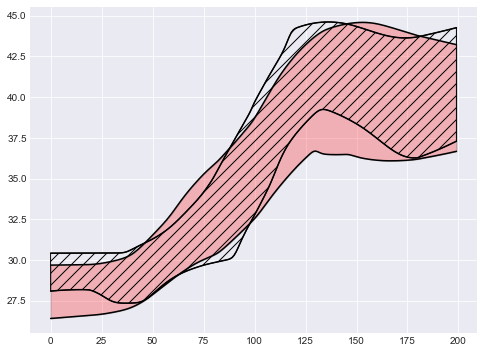

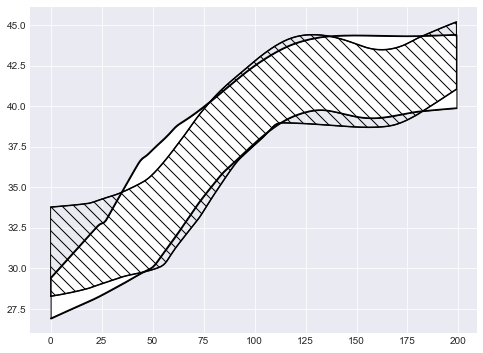

In [3]:
# constants
# mid 50 perc
percentile_threshold_upper = 0.75
percentile_threshold_lower = 0.25
# set window size
window_size = 30
max_days = 200  # capping to spring

# init df
quantile_dat = pd.DataFrame(index=range(365 - window_size), columns=["red_upper", "red_lower", "white_upper", "white_lower", "hummers_upper", "hummers_lower", "bombus_upper", "bombus_lower"])

# get quantiles for red and white flowers in each window
for loopcolor in ['red', 'white']:
    subdf = dat[(dat['color'] == loopcolor) & (dat['lon_window'] == "Lon: -96 to -59")]
    
    if len(subdf) > 0:
        for day in range(365 - window_size): # doing all year for now, capping later
            day_range = list(range(day, day + window_size))
            window_df = subdf[subdf['day_of_year'].isin(day_range)]
            
            if len(window_df) > 0:
                upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
                lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
                
                quantile_dat.loc[day, f"{loopcolor}_upper"] = upper_val
                quantile_dat.loc[day, f"{loopcolor}_lower"] = lower_val

# hummingbird quantiles
hummers_subdf = hummingbirds[hummingbirds['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = hummers_subdf[hummers_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "hummers_upper"] = upper_val
        quantile_dat.loc[day, "hummers_lower"] = lower_val

# bumblebee quantiles
bombus_subdf = bumblebees[bumblebees['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = bombus_subdf[bombus_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "bombus_upper"] = upper_val
        quantile_dat.loc[day, "bombus_lower"] = lower_val

# numeric columns
quantile_dat = quantile_dat.apply(pd.to_numeric, errors='coerce')

# backfill na vals if present
quantile_dat = quantile_dat.fillna(method='bfill')

# grey background
plt.style.use('seaborn-darkgrid')

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### Red flowers vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat['red_lower'][:max_days], quantile_dat['red_upper'][:max_days], 'red', 'Red Flowers', 0.25)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')


# save and show
plt.savefig('../hummers_red.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### White flowers vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat['white_lower'][:max_days], quantile_dat['white_upper'][:max_days], 'white', 'White Flowers', 1.0)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')

# save and show
plt.savefig('../bombus_white.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

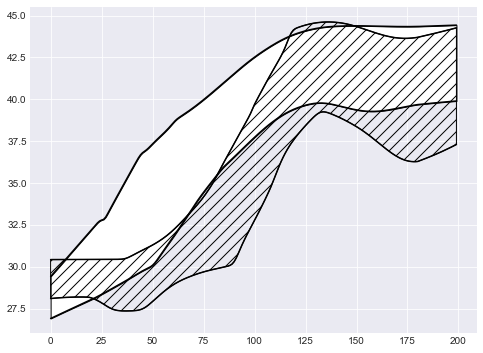

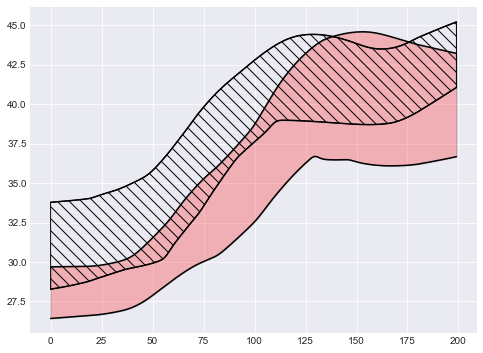

In [4]:
# gray background
plt.style.use('seaborn-darkgrid') 

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### White flowers vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat['white_lower'][:max_days], quantile_dat['white_upper'][:max_days], 'white', 'White Flowers', 1)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')

plt.savefig('../bombus_red.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### Red flowers vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat['red_lower'][:max_days], quantile_dat['red_upper'][:max_days], 'red', 'Red Flowers', 0.25)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')



plt.savefig('../hummers_white.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

# Calculate overlap between each

In [5]:
# convenience function get the percent overlap between two curves
def calculate_overlap(data1_lower, data1_upper, data2_lower, data2_upper):
    total_overlap = 0 # init at zero overlap
    total_days = len(data1_lower) # the number of days for which any arbitrary data has values
    
    for i in range(total_days): # for each day...
        # calc overlap range
        overlap_lower = max(data1_lower[i], data2_lower[i])
        overlap_upper = min(data1_upper[i], data2_upper[i])
        
        # if there's overlap...
        if overlap_lower < overlap_upper:
            overlap_range = overlap_upper - overlap_lower # get the amount of overlap
            total_range = max(data1_upper[i], data2_upper[i]) - min(data1_lower[i], data2_lower[i]) # get the total range covered
            overlap_fraction = overlap_range / total_range # divide the previous two
            total_overlap += overlap_fraction # add to total overlap
    
    # report percent
    percent_overlap = (total_overlap / total_days) * 100 # get a per-day overlap average
    return percent_overlap

# white flowers and bumblebees
white_bumble_overlap = calculate_overlap(
    quantile_dat['white_lower'][:max_days], quantile_dat['white_upper'][:max_days],
    quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days]
)

# red flowers and hummingbirds
red_hummer_overlap = calculate_overlap(
    quantile_dat['red_lower'][:max_days], quantile_dat['red_upper'][:max_days],
    quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days]
)

# red flowers and bumblebees
red_bumble_overlap = calculate_overlap(
    quantile_dat['red_lower'][:max_days], quantile_dat['red_upper'][:max_days],
    quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days]
)

# white flowers and hummingbirds
white_hummer_overlap = calculate_overlap(
    quantile_dat['white_lower'][:max_days], quantile_dat['white_upper'][:max_days],
    quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days]
)

print(f"Percent overlap between white flowers and bumblebees: {white_bumble_overlap:.2f}%")
print(f"Percent overlap between red flowers and hummingbirds: {red_hummer_overlap:.2f}%")
print(f"Percent overlap between red flowers and bumblebees: {red_bumble_overlap:.2f}%")
print(f"Percent overlap between white flowers and hummingbirds: {white_hummer_overlap:.2f}%")

Percent overlap between white flowers and bumblebees: 73.43%
Percent overlap between red flowers and hummingbirds: 70.32%
Percent overlap between red flowers and bumblebees: 32.11%
Percent overlap between white flowers and hummingbirds: 44.46%
